In [17]:
from datetime import datetime
from datetime import timezone
import polars as pl
import os

#acropolis_directory = "/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Software/quickflow/acropolis/"
acropolis_directory = "/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Database/Old"

In [18]:
#df = pl.scan_parquet(os.path.join(acropolis_directory, "pivot_measurements.parquet"))
df = pl.scan_parquet(os.path.join(acropolis_directory, "old_db_renamed_measurements.parquet"))

df = df.sort("creation_timestamp")
df.head(3).collect()

creation_timestamp,system_name,variant,gmp343_raw,gmp343_compensated,gmp343_filtered,sht45_humidity,bme280_humidity,bme280_pressure,sht45_temperature,bme280_temperature,gmp343_temperature,cal_bottle_id,wxt532_speed_avg,wxt532_speed_max,wxt532_speed_min,wxt532_direction_avg,wxt532_direction_max,wxt532_direction_min,wxt532_last_update_time,raspi_cpu_usage,raspi_disk_usage,raspi_cpu_temperature,enclosure_bme280_humidity,enclosure_bme280_pressure,enclosure_bme280_temperature,cal_gmp343_raw,cal_gmp343_compensated,cal_gmp343_filtered
"datetime[μs, UTC]",str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2023-06-01 00:00:00.960 UTC,"""tum-esm-midcos…","""system""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.031,0.426,54.5,15.1,956.48,33.77,null,null,null
2023-06-01 00:00:02.250 UTC,"""tum-esm-midcos…","""wind""",null,null,null,null,null,null,null,null,null,null,0.7,1.0,0.2,356.0,255.0,156.0,1.6856e9,null,null,null,null,null,null,null,null,null
2023-06-01 00:02:11.070 UTC,"""tum-esm-midcos…","""system""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.032,0.426,54.0,15.15,956.43,33.69,null,null,null


In [19]:
df = df.with_columns([pl.when(pl.col("cal_gmp343_filtered") < 600).then(pl.col("cal_gmp343_filtered")).otherwise(None).alias("cal_400"),
                      pl.when(pl.col("cal_gmp343_filtered") > 600).then(pl.col("cal_gmp343_filtered")).otherwise(None).alias("cal_800"),
                      pl.when(pl.col("cal_gmp343_filtered") < 600).then(pl.col("cal_bottle_id")).otherwise(None).alias("cal_bottle_id_400"),
                      pl.when(pl.col("cal_gmp343_filtered") > 600).then(pl.col("cal_bottle_id")).otherwise(None).alias("cal_bottle_id_800")])

In [20]:
dfg = df.groupby([pl.col("creation_timestamp").dt.date(), pl.col("system_name")]).agg([pl.col("cal_400").drop_nulls(),
                                                                                    pl.col("cal_800").drop_nulls(),
                                                                                    pl.col("cal_bottle_id_400").drop_nulls().median(),
                                                                                    pl.col("cal_bottle_id_800").drop_nulls().median()])

In [21]:
def average_bottle(data):
    data = data.to_list()
    #2nd bottle
    if 50 < len(data) < 70:
        x = data[int(len(data)*0.3):int(len(data)*0.95)]
        return sum(x) / len(x)
    #1st bottle
    elif 70 < len(data) > 130:
        x = data[int(len(data)*0.5):int(len(data)*0.95)]
        return sum(x) / len(x)
    else:
        return 0.0

dfg = dfg.select([pl.col("creation_timestamp"),
            pl.col("system_name"),
            pl.col("cal_400").apply(lambda x: average_bottle(x)).alias("mean_cal_400"),
            pl.col("cal_800").apply(lambda x: average_bottle(x)).alias("mean_cal_800"),
            pl.col("cal_bottle_id_400"),
            pl.col("cal_bottle_id_800")
            ])

dfg.collect()

creation_timestamp,system_name,mean_cal_400,mean_cal_800,cal_bottle_id_400,cal_bottle_id_800
date,str,f64,f64,f64,f64
2023-06-04,"""tum-esm-midcos…",0.0,0.0,null,null
2023-06-07,"""tum-esm-midcos…",0.0,0.0,null,null
2023-06-22,"""tum-esm-midcos…",0.0,0.0,null,null
2023-06-22,"""tum-esm-midcos…",0.0,0.0,null,null
2023-06-30,"""tum-esm-midcos…",390.672,789.961538,4.0,25.0
2023-07-02,"""tum-esm-midcos…",0.0,791.076923,4.0,25.0
2023-07-03,"""tum-esm-midcos…",391.34,0.0,4.0,25.0
2023-07-03,"""tum-esm-midcos…",0.0,0.0,null,null
2023-07-04,"""tum-esm-midcos…",0.0,796.764103,8.0,33.0


In [22]:
# Calculate slope and intercept

In [23]:
dfg_test = dfg.sort(pl.col("creation_timestamp")).filter(pl.col("system_name") == "tum-esm-midcost-raspi-2").filter(pl.col("mean_cal_400") > 0.0 )

dfg_test.collect()

creation_timestamp,system_name,mean_cal_400,mean_cal_800,cal_bottle_id_400,cal_bottle_id_800
date,str,f64,f64,f64,f64
2023-06-28,"""tum-esm-midcos…",390.579452,0.0,4.0,25.0
2023-06-29,"""tum-esm-midcos…",391.7,0.0,4.0,25.0
2023-06-30,"""tum-esm-midcos…",390.672,789.961538,4.0,25.0
2023-07-01,"""tum-esm-midcos…",389.889744,0.0,4.0,25.0
2023-07-03,"""tum-esm-midcos…",391.34,0.0,4.0,25.0
2023-07-05,"""tum-esm-midcos…",390.815,0.0,4.0,25.0
2023-07-06,"""tum-esm-midcos…",389.427184,786.851282,4.0,25.0
2023-07-07,"""tum-esm-midcos…",389.9375,787.146739,4.0,25.0
2023-07-09,"""tum-esm-midcos…",389.97,0.0,4.0,25.0


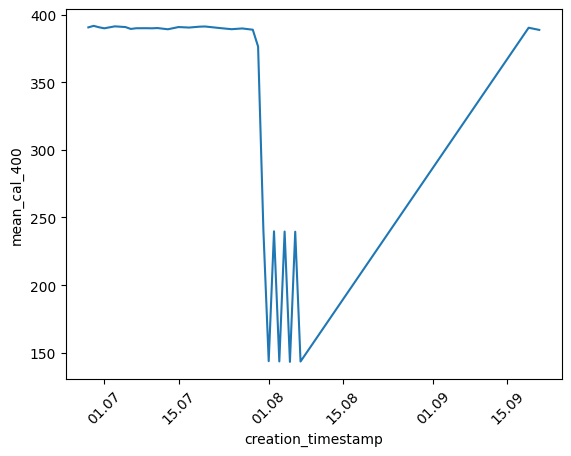

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sns.lineplot(data=dfg_test.collect(), x="creation_timestamp", y="mean_cal_400")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))